In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH222

# Studying the solvation shell of ions via Molecular Dynamics Simulations

<div class=warn>
Tasks, where you need to edit the code cells will be shown in similar "blue boxes".
<div/>

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

## Content of this notebook

#### Analysing the results

7. Analysing results

In [2]:
import hoomd
import hoomd.md
from scipy.interpolate import interp1d
from matplotlib import pyplot 
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import numpy as np
import ase
import ase.io
from ase.visualize import view
import pytraj as pt 
import nglview as nv

# 7. Compute the solvation shells

Whether you would opt for the "direct" method or the pair correlation function-based approach (see the "M15_Experimental_Protocol.pdf" document on Moodle), you need to compute the ions-solvent particles pair correlation function(S) in order to identify the cutoff radius.

<div class=warn>
    
* Compute p_cs and p_as. Plot the results on the same graph and identify the cutoff radii for the solvation shell of cations and anions.
    
</div>

### Calculating the pair correlation functions

You can calculate the pair correlation functions ***relative to a particular frame only*** using the function "py_rdf" defined below. This function takes in input the following arguments: 

* **r**   = a numpy array containing the positions of all the particles
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **n_dr** = the number of bins used to construct the distance histogram
* **dim** = the dimensionality of the system (2 or 3 D)

In [3]:
# Load the trajectory into the "traj" object:
traj = pt.load('dump.dcd', top='system.pdb')

# Access the positions of all the particles within the first frame (index = 0)

# Select the first frame [0] from the trajectory object traj
rr = traj[0]

# .xyz prints out the positions [UNITS?], which we store in the numpy array r
r = np.array(rr.xyz)


# Access the length of the box 
# Note that for a NPT simulation the box will change in time, hence we need to select the box for each frame

# .box.z prints the magnitude of the cell vector aligned with the z axis. 
# As we are using a cubic simulation box (identified via three cell vectors of equal length aligned
# along the x, y and axis), you - could - also use .box.y and .box.x
# NOTE: do - not - use .box.x, though (bug!)
# We store this number in the variable S, which represents the length of the box [UNITS?]
S = rr.box.z

In [4]:
def py_rdf(r, S, n_dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles  = len(r)
    rMax           = S/2.0;
    dr             = rMax/n_dr
    edges          = np.linspace(0., rMax + dr, num=n_dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity  = len(r) / S**dim

    # Compute pairwise correlation for each particle
    
    for index in range(num_particles): # Loop over all the particles

        d = 0.0
        for i in range(dim):
            
            # Set of distances (components x, y and z as indicated by the index "i")
            # between the particle specified by the index "index" and all the other particles (note the ":")
            dp = absolute(r[index,i] - r[:,i]) 
            
            # Condition: a distance component is longer than half of the box
            # If it is, we need to account for the PBC
            mask = dp>S/2.0
            
            # If the condition above is verified, scale the distance to the actual PBC-corrected distance
            dp[mask] = S - dp[mask]
            
            # Calculate the distance (squared) from the distance components
            # That is, d = dp_x**2 + dp_y**2 + dp_z**2
            d += dp*dp

        # Distance    
        d = sqrt(d)
        
        # The distance between the particle specified by the index "index" and itself - that is, the box length!
        d[index] = 2 * rMax

        # Build a histogram of all the distances we have computed
        (result, bins) = histogram(d, bins=edges, density=False)
        
        # Sum the histogram for each particle
        g += result

    # Normalize the histogram
    g = g/(num_particles * numberDensity)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 3D
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i])

    return (radii, g)

In [5]:
n_dr=50

# Compute the g(r). dist contains the distances (x-axis), pcf_all contains the g(r)
dist, pcf_all = py_rdf(r, S, n_dr, 3)

In [6]:
# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

tdf = interp1d(dist, pcf_all, kind="cubic")
tdx = np.linspace(safe, (S/2.0)-safe, num=res, endpoint=True)

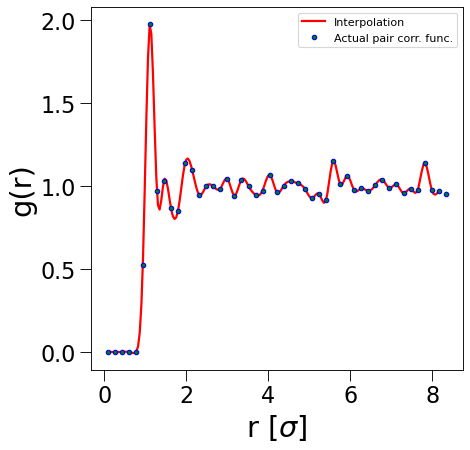

In [7]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r)
plt.plot(tdx, tdf(tdx), color='red', linestyle='solid', linewidth=2.0, label='Interpolation') 

# Actual g(r) points
plt.plot(dist, pcf_all, 'o', markerfacecolor='green', markersize=4, markeredgecolor='blue', 
         linewidth=2.5, label='Actual pair corr. func.')

plt.legend()
plt.xlabel('r [$\sigma$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

### Cross correlations
What we have computed above is the g(r) for ***all*** the particles in the system. In order to compute the solvation shell of, for instance, the cations, we need to compute the cations-solvent pair correlation function. Solvent particles have been labeled as "S", while cations have been labeled as "C". One way to proceed is to build two different numpy arrays containing the positions of S and C only. At that point, we can modify the ```py_rdf``` function so as to compute the distances between S and C particles only. The one thing left to modify would be the normalization factor. In the previous case (i.e. the g(r) of the entire system) we have divided the histogram of the distance by the number of particles times the density of the system. In here, we will have to divide by the number of C particles times the density of system for the S particles only.

In [8]:
# Load the trajectory into the "traj" object - AGAIN
# In principle this is not needed - however, failing to re-load will kill the kernel
# if one runs the entire Notebook from top to bottom...
traj = pt.load('dump.dcd', top='system.pdb')

# Access the positions of the C particles only within frame 0
rr_C = traj['@C',0]
r_C = np.array(rr_C.xyz)

# Access the positions of the S particles only within frame 0
rr_S = traj['@S',0]
r_S = np.array(rr_S.xyz)

<div class=warn>
    
* Modify the function below so as to compute a generic pair correlation function between A and B particles. The sections of the code for you to modify are tagged as "MODIFY"
    
</div>

In [9]:
# Modified py_rdf function that computes the pair correlation function for two groups of particles
# We need as input two arrays of positions for particles A and B

def py_rdf_AB(r_A, r_B, S, n_dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles_A  = len(r_A)
    num_particles_B  = len(r_B)
    rMax           = S/2.0;
    dr             = rMax/n_dr
    edges          = np.linspace(0., rMax + dr, num=n_dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity_A  = len(MODIFY) / S**dim
    numberDensity_B  = len(MODIFY) / S**dim

    # Compute pairwise correlation
    
    # Loop over particles A
    for index in range(MODIFY):

        d = 0.0
        for i in range(dim):
            
            # (Components of the) distances between each particle A and all the particles B
            dp = absolute(MODIFY[index,i] - MODIFY[:,i])
            mask = dp>S/2.0
            dp[mask] = S - dp[mask]
            d += dp*dp

        d = sqrt(d) # array containing the num_particles distances from particle index to all other particles
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    # Normalise by the number of B particles and the number density for A particles only    
    g = g/(MODIFY * MODIFY)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 3D
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i])

    return (radii, g)

<div class=warn>
    
* Calculate the average number of solvent particles within the solvation shell of the cations/anions.
    1. Use the ```py_rdf_AB``` you have modified above to compute the cations/anions-solvent pair correlation functions (PCFs). Note that **you will need to average the PCFs across the MD trajectory**. Tip: you might want to avoid that section of the trajectory corresponding to the initial equilibration when averaging your PCFs.
    
    2. Identify the cutoff radius corresponding to the extent of the cations/anions solvation shell. Plotting the PCFs might help. Tip: Several Python packages (see [here](https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/) for an overview) allow you to quickly locate the extrema of a given function. 
    
    3. Compute the average number of solvent particles within the solvation shell of the cations/anions using the cutoff radii you have identified. You can either:
    
        - Do that "directly", by identifying how many particles lie within the cutoff for each cation/anions.
    
        - Integrate the PCFs up to the cutoff radius. This is much faster than the direct method, as you have computed the PCFs already. Tip: You can use the "CW_1_Key.ipnyb" Notebook we have used for CH273 as a starting point, but **remember to sum the area corresponding to each bin** (we didn't do that in "CW_1_Key.ipnyb"). 
    
</div>

<div class=warn>
    
* Investigate the changes in the solvation shells observed upon the modification of the size of the cations and/or anions. You can achieve this by modifying the values of $sigma$, for instance ```lj.pair_coeff.set('Solvent', 'Cation', epsilon=1.0, sigma=1.5)```. We recommend to explore values of $sigma$ within 1 and 2.
    
</div>